<a href="https://colab.research.google.com/github/hwang-UofT/test/blob/main/Project%202%3A%20How_does_the_room_type_and_location_of_an_Airbnb_listing_affect_its_listing_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project One

## Introduction

In this assignment I will be exploring Airbnb rental price data in New York City. Specifically, I am interest in answering, 
"How does the room type and location of an Airbnb listing affect it's price, in New York City?"

The data set I will be working with is from Inside Airbnb, retrieved from http://insideairbnb.com/index.html.

To be more specific my response variable(Y) will the price in dollars per night of an New York City Airbnb.

My first explanatory variable(X1) will the type of room the listing is for, I will investigate the types later on in the assignment.

My second explanatory variable(X2) will be the the location of the listing. I will be using the neighourhood of New York City the listing is in to classify location.

In the data room_type is the room type of the listing and neighbourhood_group is the neighbourhood of New York City the listing is located in.


In [ ]:
# Uncomment following line to install on colab
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes pygeos rtree

     |████████████████████████████████| 14.8MB 325kB/s 
     |████████████████████████████████| 1.0MB 51.2MB/s 
     |████████████████████████████████| 1.7MB 27.8MB/s 
     |████████████████████████████████| 2.1MB 41.6MB/s 
     |████████████████████████████████| 1.0MB 32.2MB/s 
     |████████████████████████████████| 235kB 45.0MB/s 
     |████████████████████████████████| 6.5MB 49.7MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-cp37-none-any.whl size=27812 sha256=0bc88e3faecb9ff0c788d1dbb7cbac73fed3362a1252e3ce45874631cfa8c893
  Stored in directory: /root/.cache/pip/wheels/39/c9/24/c025651bbe9ce3298631f6f7d933c3f8c61b1d50b720762f9d
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=dcbd1202bcfcfa36feb5c7af5da26e8f1eedf4a64d8b95f4f9c3270898db91e6
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built qeds pyLDAvis


In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
from google.colab import files

import geopandas as gpd

from shapely.geometry import Point

import matplotlib.cm as cm
from matplotlib.colors import Normalize 

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
# read the data in using pandas
data_raw=pd.read_csv('AB_NYC_2019.csv')

data_raw = pd.DataFrame(data_raw)

# let's take a look at the top 5 rows of our raw data set
data_raw.head()

id  ... availability_365
0  2539  ...              365
1  2595  ...              355
2  3647  ...              365
3  3831  ...              194
4  5022  ...                0

[5 rows x 16 columns]

## Cleaning Data

In [ ]:
# Let's take create a subset of the dataframe to only include the columns we will need

data = data_raw[["id", "price", "room_type", 'neighbourhood_group']]
data.head()

# Below we can see that our new data only has the 4 columns we need.

id  price        room_type neighbourhood_group
0  2539    149     Private room            Brooklyn
1  2595    225  Entire home/apt           Manhattan
2  3647    150     Private room           Manhattan
3  3831     89  Entire home/apt            Brooklyn
4  5022     80  Entire home/apt           Manhattan

In [ ]:
# taking a look at the types of our data
data.dtypes

id                      int64
price                   int64
room_type              object
neighbourhood_group    object
dtype: object

We see that id, price are numerical data while room_type and neighbourhood_group are categorical data

In [ ]:
# Clean our data by droping rows with a nans in any of the columns
print("There are {} missing values in the data set".format(data_raw.isnull().values.sum()))

data_no_na = data.dropna(axis=0, how='any')

There are 20141 missing values in the data set


## Summary Statistics

In [ ]:
# Lets pull up the summary statistics of our data
data.describe().T

count          mean           std  ...         50%         75%         max
id     48895.0  1.901714e+07  1.098311e+07  ...  19677284.0  29152178.5  36487245.0
price  48895.0  1.527207e+02  2.401542e+02  ...       106.0       175.0     10000.0

[2 rows x 8 columns]

First we can see that we have 48895 observations in the data set. We see that the mean price of Airbnb listing is for 152 dollars per night. The standard deviation of prices is 240. Interestingly, the cheapest listing is for 0 a night, which may be human error, and the most expensive listing is for 10000 dollars a night. We are also given the 25%, 50% and 75% percentiles.

We can ignore the id as the values are meaningless and is only used for identification.

In [ ]:
# Unique values for room_type and neighbour_hood group

print("There are {} unique room_types in the data which are are: {}".format(data['room_type'].nunique() ,data['room_type'].unique()))
print("There are {} unique neighbourhood_groups in the data which are: {} ".format(data['neighbourhood_group'].nunique(), data['neighbourhood_group'].unique()))

There are 3 unique room_types in the data which are are: ['Private room' 'Entire home/apt' 'Shared room']
There are 5 unique neighbourhood_groups in the data which are: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx'] 


We can see that there are 3 unique room types in the data which are 'Private room,' 'Entire home/apt' and 'Shared room'. 
Entire home/apt means that the entire unit is listed, whether it was a home or apartment.

There are 5 unique New York City neighbourhoods in our data which are; 'Brooklyn', 'Manhattan','Queens', 'Staten Island' and 'Bronx'.

## Histogram of Price, Room type and Neighbourhood

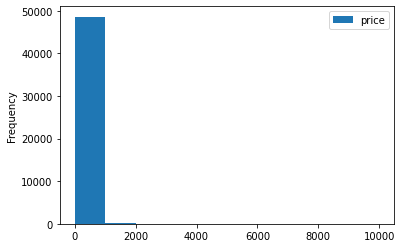

In [ ]:
data[['price']].plot(kind='hist')

We can see that the majority of listings fall below 1000 dollars per night price. There seems to be a few listing between 1000 
and 2000 dollars a night and very few listings over the price of 2000 per night.

Text(0, 0.5, 'Frequency')

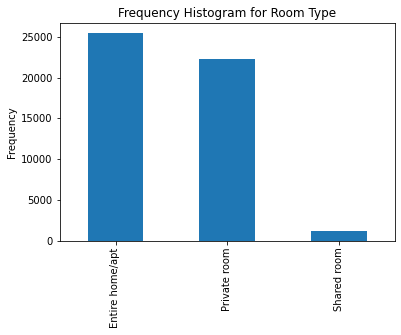

In [ ]:
data['room_type'].value_counts().plot(kind='bar')
plt.title("Frequency Histogram for Room Type")
plt.ylabel("Frequency")

From the histogram above, we note that most listings in New York City is for the entire home/apartment. The second most popular listed room type are private rooms and the least popular, by far, are shared rooms. This suggests that many hosts understand the value of privacy for customers.

Text(0, 0.5, 'Frequency')

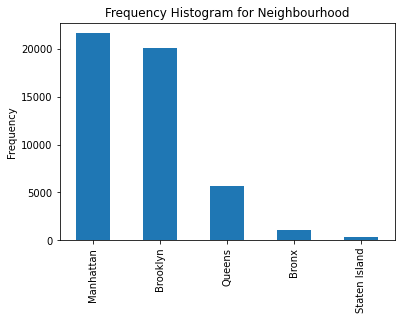

In [ ]:
data['neighbourhood_group'].value_counts().plot(kind='bar')
plt.title("Frequency Histogram for Neighbourhood")
plt.ylabel("Frequency")

From the histogram above, we can see the number of listings in each neighbourhood in New York City. In descending order; Manhattan, Brooklyn, Queens, Bronx and Staten Island. The majority of listings are found in either Manhattan and Brooklyn, this may suggest that Manhattan and Brooklyn are popular tourist destinations which high demand for AirBnbs. 

Text(0.1, -0.27, '\n    This figure shows the total number of AirBnb listings\n    in the neighbourhoods of NYC.\n    \n    Data is retrieved from InsideAirbnb.\n    (http://insideairbnb.com/index.html)\n    Created by: Howard Wang for ECO225 Week 4 Excerise \n    ')

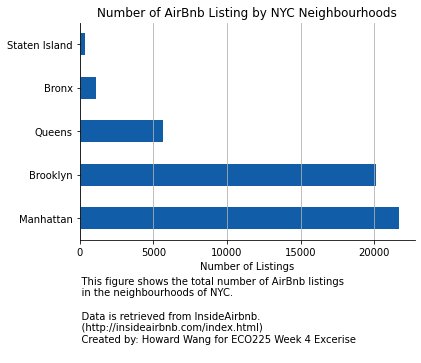

In [ ]:
## 20201-02-10 Week 4 Excerise Q3
bgcolor = (250/255, 250/255, 250/255)
txt = '''
    This figure shows the total number of AirBnb listings
    in the neighbourhoods of NYC.
    
    Data is retrieved from InsideAirbnb.
    (http://insideairbnb.com/index.html)
    Created by: Howard Wang for ECO225 Week 4 Excerise 
    '''

fig, ax = plt.subplots()
data['neighbourhood_group'].value_counts().plot(kind='barh', ax=ax, color="#115DA8")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Number of AirBnb Listing by NYC Neighbourhoods")

ax.set_xlabel("Number of Listings")
plt.grid(axis='x')


fig.text(0.1,-0.27,txt)


## Visualizing Price to Room Type and Price to Neighbourhood

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

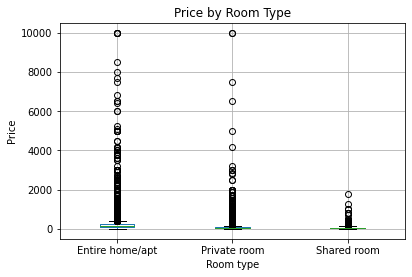

In [ ]:
# Since room_type is a categorical data, lets creates a boxplot to take a look
# at how price differs by room_type

data.boxplot(column = 'price', by = "room_type")
plt.xlabel("Room type")
plt.ylabel("Price")
plt.title("Price by Room Type")
plt.suptitle("")

In the plot above, we can see how price differs by room type. There seems to be a larger variation in prices for listings of the entire home/apartment and private room type compared to shared rooms which are all under 2000 dollars a night. There are more expensive listings for the entire home/apartment compared to private rooms. This make sense as we expect consumers are willing to pay more for more privacy and a larger space. For all three room types, the majority of the room prices are far below 2000.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

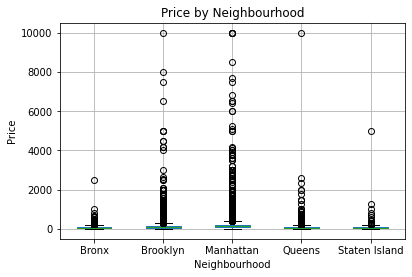

In [ ]:
data.boxplot(column = 'price', by = "neighbourhood_group")
plt.xlabel("Neighbourhood")
plt.ylabel("Price")
plt.title("Price by Neighbourhood")
plt.suptitle("")

In the plot above, we can see how price differs between the neighbourhoods of New York City. The majority of listings in the Bronx, Queens and Staten Island fall below 2000, which a few exceptions. Although the majority of listings are similar across all neighourhoods, Brooklyn and Manhattan have a number of listings over 2000 dollar listing price.  As we saw before, Brooklyn and Manhattan were the most popular in terms of listings, so it may not come as a surprise that there are out outliers in Brooklyn and Manhattan.

## Summary

In first project, I found interesting results on how pricing of a Airbnbs listing is affected why its room type and its neighbourhood in New York City. We found that there is a larger variation in prices for Airbnb listings of entire homes/apartments and private rooms compared to shared rooms. I also discovered that we see an greater variation in prices for listings in Brooklyn and Manhattan compared to listings in Bronx, Queens and Staten Island. We discovered that Brooklyn and Manhattan were the neighbourhoods with the most listings. We also discovered that there was many more entire homes/apartments and private room listed compared to shared rooms and they also had more expensive options which may suggest that consumers demand for and value privacy.

## Future Steps

In the future I would want to look into fitting a linear model that predicts the price provided a Airbnb's listing and room type. I would want to analyze my model to reach a conclusion for my research question of what is the effect a Airbnb listing's room type and neighbourhood has on its price.

In [ ]:
# Week 5 Excerise 2
county_df = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip")

HTTPError: ignored

In [ ]:
county_df.head()

STATEFP  ...                                           geometry
0      31  ...  POLYGON ((-97.01952 42.00410, -97.01952 42.004...
1      53  ...  POLYGON ((-123.43639 46.23820, -123.44759 46.2...
2      35  ...  POLYGON ((-104.56739 33.99757, -104.56772 33.9...
3      31  ...  POLYGON ((-96.91075 40.78494, -96.91075 40.790...
4      31  ...  POLYGON ((-98.27367 40.08940, -98.27367 40.089...

[5 rows x 18 columns]

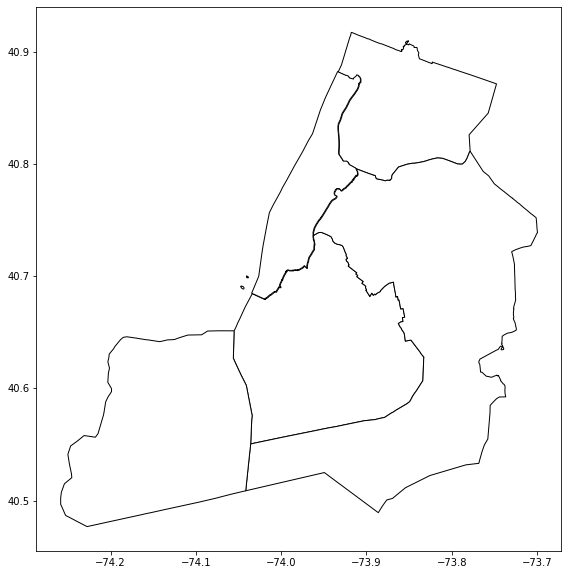

In [ ]:
fig, gax = plt.subplots(figsize=(10, 10))

county_df.query("GEOID == '36005'").plot(ax=gax, edgecolor="black", color="white")
county_df.query("GEOID == '36047'").plot(ax=gax, edgecolor="black", color="white")
county_df.query("GEOID == '36061'").plot(ax=gax, edgecolor="black", color="white")
county_df.query("GEOID == '36081'").plot(ax=gax, edgecolor="black", color="white")
county_df.query("GEOID == '36085'").plot(ax=gax, edgecolor="black", color="white")


plt.show()

In [ ]:
data_final = data_raw.dropna(axis=0, how='any')

data_final["geometry"] = list(zip(data_final.longitude, data_final.latitude))
data_final["geometry"] = data_final["geometry"].apply(Point)
gdf = gpd.GeoDataFrame(data_final,crs = 4326, geometry="geometry")

gdf.head()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


id  ...                    geometry
0  2539  ...  POINT (-73.97237 40.64749)
1  2595  ...  POINT (-73.98377 40.75362)
3  3831  ...  POINT (-73.95976 40.68514)
4  5022  ...  POINT (-73.94399 40.79851)
5  5099  ...  POINT (-73.97500 40.74767)

[5 rows x 17 columns]

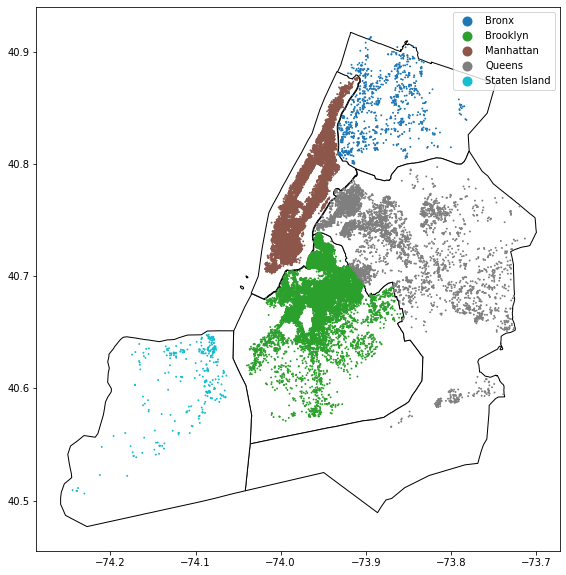

In [ ]:
fig, gax = plt.subplots(figsize=(10, 10))

# plot the five boroughs of NYC
county_df.query("GEOID == '36005'").plot(ax=gax, edgecolor="black", color="white")
county_df.query("GEOID == '36047'").plot(ax=gax, edgecolor="black", color="white")
county_df.query("GEOID == '36061'").plot(ax=gax, edgecolor="black", color="white")
county_df.query("GEOID == '36081'").plot(ax=gax, edgecolor="black", color="white")
county_df.query("GEOID == '36085'").plot(ax=gax, edgecolor="black", color="white")

gdf.plot(ax=gax, column = 'neighbourhood_group', legend = True, markersize = .8)

plt.show()

In [ ]:
gdf_ny = gpd.read_file("ZillowNeighborhoods-NY.shp")

gdf_ny = gdf_ny[gdf_ny['CITY'].str.contains("New York City")]

gdf_ny["CITY"].replace({"New York City-Manhattan	": "Manhattan",
                     "New York City-Brooklyn": "Brooklyn",
                     "New York City-Staten Island": "Staten Island",
                     "New York City-Queens": "Queens",
                     "New York City-Bronx" : "Bronx" 
                    }, inplace = True)

gdf_ny["COUNTY"].replace({"New York": "Manhattan",
                     "Kings": "Brooklyn",
                     "Richmond": "Staten Island"
                    }, inplace = True)

gdf_2 = gpd.sjoin(gdf, gdf_ny)

gdf_2.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None



id                                   name  ...          NAME  REGIONID
0      2539     Clean & quiet apt home by the park  ...  Borough Park  193406.0
258   63546         Large and Cozy Private Bedroom  ...  Borough Park  193406.0
397  125594     SUPER BIG AND COZY PRIVATE BEDROOM  ...  Borough Park  193406.0
738  267652  Private clean pleasant spacious room.  ...  Borough Park  193406.0
786  282341    Kensington/Ditmas Park pied-a-terre  ...  Borough Park  193406.0

[5 rows x 23 columns]

STATE  ...                                           geometry
1    NY  ...  POLYGON ((-74.01399 40.72991, -74.01381 40.731...
2    NY  ...  POLYGON ((-74.02167 40.60318, -73.99913 40.624...
4    NY  ...  POLYGON ((-73.98734 40.73372, -73.97184 40.727...
7    NY  ...  POLYGON ((-73.80413 40.73780, -73.80372 40.741...
8    NY  ...  POLYGON ((-74.06105 40.60723, -74.06102 40.607...

[5 rows x 6 columns]

# Project 2

## Part 1 - Addressing Comments

In this assignment I will be exploring Airbnb rental price data in New York City. Specifically, I am interest in answering, 
"How does Airbnb listing prices differ between room types and the different bourghs of New York City?"

The data set I will be working with is from Inside Airbnb, retrieved from http://insideairbnb.com/index.html.

To be more specific my response variable(Y) will the price in dollars per night of an New York City Airbnb.

My first explanatory variable(X1) will the type of room the listing is for, I will investigate the types later on in the assignment.

My second explanatory variable(X2) will be the the location of the listing. To classify location, I will be using the neighourhood in New York City for which the listing is located.

In the data room_type is the room type of the listing and neighbourhood_group is the neighbourhood of New York City the listing is located in.

  In the first part of this notebook I will be importing the required libraries and load in the required data.
  Next, I will clean our data set and run summary statistics.
  Finally, I will prepare our data to create visualiations of how price differs between location and room types.


### Setup


In [1]:
# Uncomment following line to install on colab
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes pygeos rtree

     |████████████████████████████████| 14.8MB 299kB/s 
     |████████████████████████████████| 1.0MB 47.7MB/s 
     |████████████████████████████████| 1.7MB 42.8MB/s 
     |████████████████████████████████| 2.1MB 45.6MB/s 
     |████████████████████████████████| 1.0MB 46.2MB/s 
     |████████████████████████████████| 235kB 51.0MB/s 
     |████████████████████████████████| 6.5MB 34.9MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-cp37-none-any.whl size=27812 sha256=a96b80f8bff0c289c6283e82c553e4fe3b2c059b37c9bae0302c4575a5984883
  Stored in directory: /root/.cache/pip/wheels/39/c9/24/c025651bbe9ce3298631f6f7d933c3f8c61b1d50b720762f9d
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=08969cf5c338296215a9d89a8dd8d8263fdd1c9a1eaa22bc457ce9ac19c6c7d2
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built qeds pyLDAvis


In [3]:
# Import Libraries
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
from google.colab import files

import geopandas as gpd

from shapely.geometry import Point

import matplotlib.cm as cm
from matplotlib.colors import Normalize 

%matplotlib inline

### Reading and preping dataframes 

In [4]:
# read the data in using pandas
data_raw=pd.read_csv('AB_NYC_2019.csv')

data_raw = pd.DataFrame(data_raw)

# filter the rows we need
data = data_raw[["id", "price", "room_type", 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude']]

data.head(2)
# Below we can see that our new data only has the columns we need.

id  price        room_type  ... neighbourhood  latitude  longitude
0  2539    149     Private room  ...    Kensington  40.64749  -73.97237
1  2595    225  Entire home/apt  ...       Midtown  40.75362  -73.98377

[2 rows x 7 columns]

In [5]:
# taking a look at the types of our data
data.dtypes

id                       int64
price                    int64
room_type               object
neighbourhood_group     object
neighbourhood           object
latitude               float64
longitude              float64
dtype: object

We see that id, price are numerical data while room_type and neighbourhood_group are categorical data

In [6]:
# Clean our data by droping rows with a nans in any of the columns
print("There are {} missing values in the data set".format(data.isnull().values.sum()))

There are 0 missing values in the data set


Since there are 0 missing values in our filtered data set, we do not need to drop any rows!

In [7]:
# Get discriptive statistics of Y variable: Listing price
data.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

First we can see that we have 48895 observations in the data set. We see that the mean price of Airbnb listing is for 152 dollars per night. The standard deviation of prices is 240. Interestingly, the cheapest listing is for 0 a night, which may be human error, and the most expensive listing is for 10000 dollars a night. We are also given the 25%, 50% and 75% percentiles.

We can ignore other numerical columns such as id, latitude and longitude as the summary statistics are meaningless.

We notice that the 75% percentile price is 175, while the max is 100000. This suggets that we may have some outliers in our data. Let's take a look at the the different quantiles of our price data.

In [8]:
data.price.quantile(np.arange(0,1.01,0.05))

0.00        0.0
0.05       40.0
0.10       49.0
0.15       55.0
0.20       60.0
0.25       69.0
0.30       75.0
0.35       81.0
0.40       90.0
0.45      100.0
0.50      106.0
0.55      120.0
0.60      130.0
0.65      149.0
0.70      155.0
0.75      175.0
0.80      200.0
0.85      225.0
0.90      269.0
0.95      355.0
1.00    10000.0
Name: price, dtype: float64

We see that 355 dollars per night is the 95% percentile of our data. This means that only 5 of listings were within the 355 to 10000 dollar range, while 95% of lisings prices were less 355 dollars. Let's drop the outliers at the 95th percentile to get a visualization of our graph.

In [9]:
# filter data set
data_95th = data.query("price <= 355")

In [ ]:
# Unique values for room_type and neighbour_hood group

print("There are {} unique room_types in the data which are are: {}".format(data['room_type'].nunique() ,data['room_type'].unique()))
print("There are {} unique neighbourhood_groups in the data which are: {} ".format(data['neighbourhood_group'].nunique(), data['neighbourhood_group'].unique()))

We can see that there are 3 unique room types in the data which are 'Private room,' 'Entire home/apt' and 'Shared room'. Entire home/apt means that the entire unit is listed, whether it was a home or apartment.

There are 5 unique New York City neighbourhoods in our data which are; 'Brooklyn', 'Manhattan','Queens', 'Staten Island' and 'Bronx'.

### Summary Statistics and Data Exploration

Text(0.1, -8100, '\n    This figure plots the frequency of listings at\n    each price range. The data is a subset of\n    listings with price less or equal to the\n    95th percentile of 355 dollars per night.\n    \n    Data is retrieved from InsideAirbnb.\n    (http://insideairbnb.com/index.html)\n    Created by: Howard Wang for ECO225\n    ')

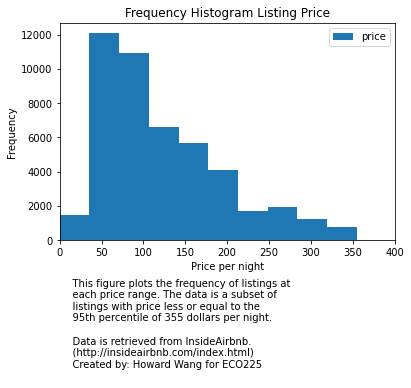

In [50]:
txt = '''
    This figure plots the frequency of listings at
    each price range. The data is a subset of
    listings with price less or equal to the
    95th percentile of 355 dollars per night.
    
    Data is retrieved from InsideAirbnb.
    (http://insideairbnb.com/index.html)
    Created by: Howard Wang for ECO225
    '''


data_95th[['price']].plot(kind='hist')
plt.title("Frequency Histogram Listing Price")
plt.xlabel("Price per night")
plt.xlim(0, 400)
plt.text(0.1,-8100, txt)

We can see that the majority of listings fall below 100 dollars per night price. There is a decreasing number of listings as price increases.

Text(0.1, -0.27, '\n    This figure shows the total number of AirBnb listings\n    by room type in NYC.\n    \n    Data is retrieved from InsideAirbnb.\n    (http://insideairbnb.com/index.html)\n    Created by: Howard Wang for ECO225\n    ')

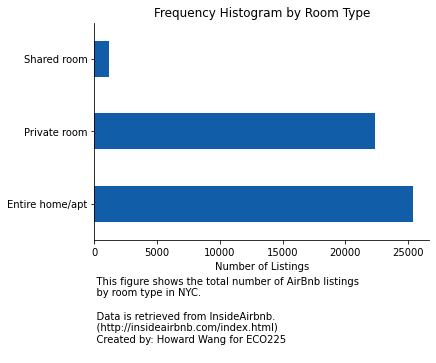

In [23]:

txt = '''
    This figure shows the total number of AirBnb listings
    by room type in NYC.
    
    Data is retrieved from InsideAirbnb.
    (http://insideairbnb.com/index.html)
    Created by: Howard Wang for ECO225
    '''

fig, ax = plt.subplots()
data['room_type'].value_counts().plot(kind='barh', ax=ax, color="#115DA8")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Frequency Histogram by Room Type")

ax.set_xlabel("Number of Listings")
#plt.grid(axis='x')

fig.text(0.1,-0.27,txt)

From the histogram above, we note that most listings in New York City is for the entire home/apartment. The second most popular listed room type are private rooms and the least popular, by far, are shared rooms. This suggests that many hosts understand the value of privacy for customers.

Text(0.1, -0.27, '\n    This figure shows the total number of AirBnb listings\n    in the neighbourhoods of NYC.\n    \n    Data is retrieved from InsideAirbnb.\n    (http://insideairbnb.com/index.html)\n    Created by: Howard Wang for ECO225\n    ')

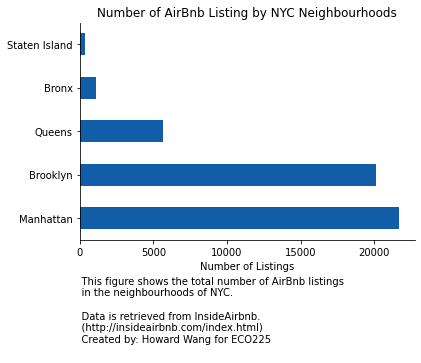

In [22]:

txt = '''
    This figure shows the total number of AirBnb listings
    in the neighbourhoods of NYC.
    
    Data is retrieved from InsideAirbnb.
    (http://insideairbnb.com/index.html)
    Created by: Howard Wang for ECO225
    '''

fig, ax = plt.subplots()
data['neighbourhood_group'].value_counts().plot(kind='barh', ax=ax, color="#115DA8")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Number of AirBnb Listing by NYC Neighbourhoods")

ax.set_xlabel("Number of Listings")
#plt.grid(axis='x')


fig.text(0.1,-0.27,txt)

From the histogram above, we can see the number of listings in each neighbourhood in New York City. In descending order; Manhattan, Brooklyn, Queens, Bronx and Staten Island. The majority of listings are found in either Manhattan and Brooklyn, this may suggest that Manhattan and Brooklyn are popular tourist destinations which high demand for AirBnbs. 

### Visualizing Price to Room Type and Price to Neighbourhood

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

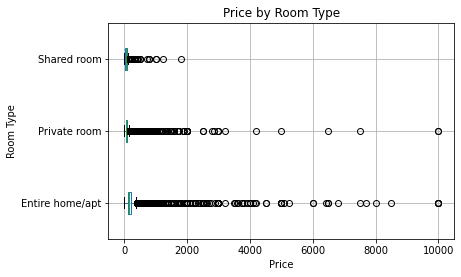

In [52]:
# Since room_type is a categorical data, lets creates a boxplot to take a look
# at how price differs by room_type

data.boxplot(column = 'price', by = "room_type", vert=False)
plt.xlabel("Price")
plt.ylabel("Room Type")
plt.title("Price by Room Type")
plt.suptitle("")

In the plot above, we can see how price differs by room type. There seems to be a larger variation in prices for listings of the entire home/apartment and private room type compared to shared rooms which are all under 2000 dollars a night. There are more expensive listings for the entire home/apartment compared to private rooms. This make sense as we expect consumers are willing to pay more for more privacy and a larger space. For all three room types, the majority of the room prices are far below 2000.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

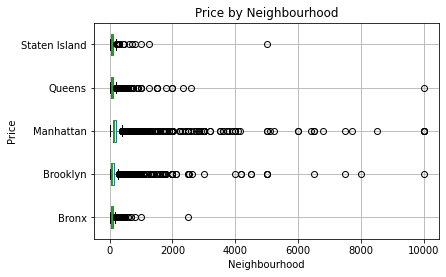

In [54]:
data.boxplot(column = 'price', by = "neighbourhood_group", vert=False)
plt.xlabel("Neighbourhood")
plt.ylabel("Price")
plt.title("Price by Neighbourhood")
plt.suptitle("")

In the plot above, we can see how price differs between the neighbourhoods of New York City. The majority of listings in the Bronx, Queens and Staten Island fall below 2000, which a few exceptions. Although the majority of listings are similar across all neighourhoods, Brooklyn and Manhattan have a number of listings over 2000 dollar listing price.  As we saw before, Brooklyn and Manhattan were the most popular in terms of listings, so it may not come as a surprise that there are out outliers in Brooklyn and Manhattan.

### Maps 1

In [211]:
county_df = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip")
county_df.head(2)

STATEFP  ...                                           geometry
0      31  ...  POLYGON ((-97.01952 42.00410, -97.01952 42.004...
1      53  ...  POLYGON ((-123.43639 46.23820, -123.44759 46.2...

[2 rows x 18 columns]

In [173]:
# create a geometry column used as that applies Point function to longitude and latitude
data["geometry"] = list(zip(data.longitude, data.latitude))
data["geometry"] = data["geometry"].apply(Point)

# create a geodataframe from our pandas dataframe
gdf = gpd.GeoDataFrame(data, crs= 4326, geometry="geometry")

gdf.head(2)

id  price  ... longitude                    geometry
0  2539    149  ... -73.97237  POINT (-73.97237 40.64749)
1  2595    225  ... -73.98377  POINT (-73.98377 40.75362)

[2 rows x 8 columns]

In [212]:
# Filtered by GEOID for the 5 boughs of NYC
county_df = county_df.query("GEOID in ['36005', '36047', '36061', '36081', '36085']")

# made naming changes to match county data with airbnb data
county_df["NAME"].replace({
    "Kings": "Brooklyn",
    "New York": "Manhattan",
    "Richmond": "Staten Island"}, inplace = True)

county_df

STATEFP  ...                                           geometry
1399      36  ...  POLYGON ((-74.25909 40.49956, -74.25909 40.499...
2333      36  ...  POLYGON ((-74.03813 40.53829, -74.03749 40.542...
2409      36  ...  POLYGON ((-74.05647 40.63171, -74.05626 40.637...
2446      36  ...  MULTIPOLYGON (((-74.03294 40.68778, -74.02628 ...
3162      36  ...  POLYGON ((-73.93365 40.88246, -73.93173 40.885...

[5 rows x 18 columns]

Text(0.5, 1.0, 'Airbnb Listing prices by Neighbourhood Group in NYC')

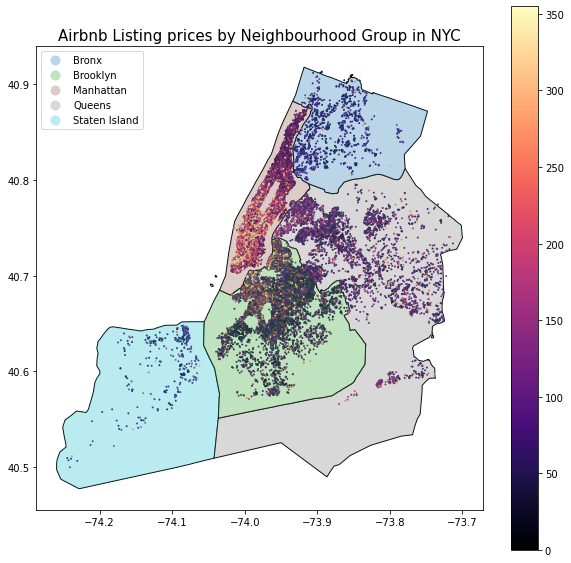

In [138]:
# Plot listings and prices on map
fig, gax = plt.subplots(figsize=(10, 10))
county_df.plot(ax=gax, edgecolor = 'black', color='white')
gdf.plot(ax=gax, column = 'price',  vmin=0, vmax=355, markersize = .9, legend = True, cmap='magma')

county_df.plot(column = "NAME", legend = True, alpha = 0.3, ax = gax)
gax.set_title("Airbnb Listing prices by Neighbourhood Group in NYC", fontsize = 15)

We can see from the plot above that listings in Brooklyn and Manhattan had a wide range of prices. Airbnbs' with a low and high listings prices were found in Manhattan and Brooklyn, while Bronx, Staten Island and Queens mainly had cheaper listings. South Manhattan stands out with the most number of listings with high listing prices.

Text(0.5, 471.3016530058778, 'Longtitude')

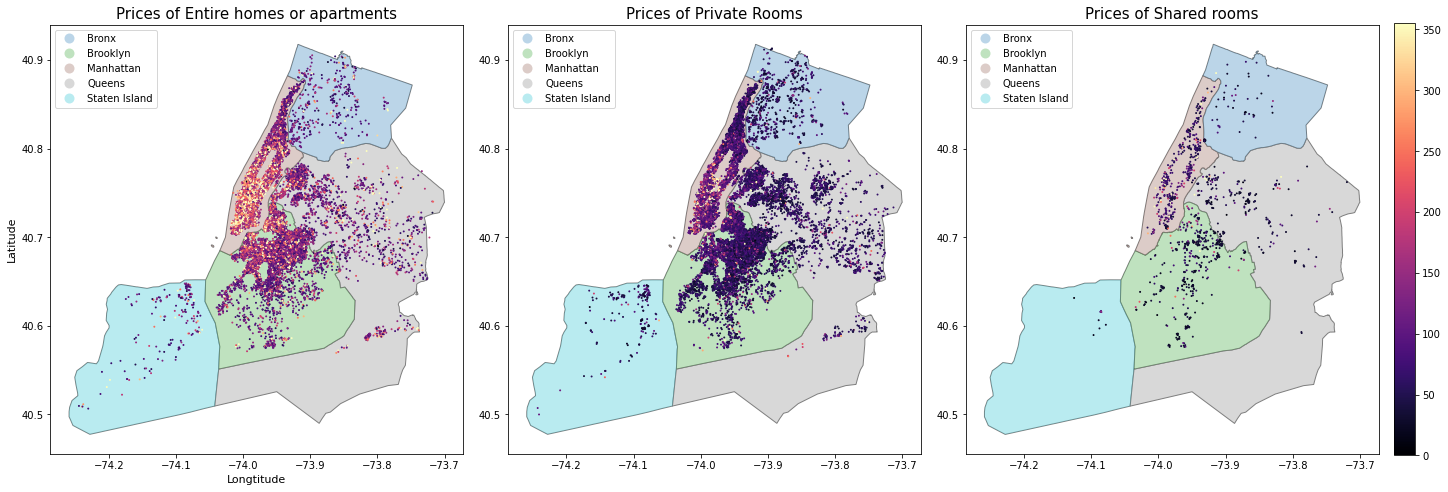

In [135]:
# Now lets take a look at how the average listing price looks
fig, gax = plt.subplots(1, 3, figsize=(20,20), constrained_layout=True)

for ax in gax.reshape(-1):
  county_df.plot(ax = ax, edgecolor = "grey", color = "white")
  county_df.plot(column = "NAME", legend = True, alpha = .3, ax = ax)

# filter and map entire hooms/apt
ent_room = gdf.query("room_type == 'Entire home/apt'")
ent_room.plot(ax=gax[0], column = 'price',  vmin=0, vmax=355, markersize = .9, cmap='magma')

# filter and map entire private
pri_room = gdf.query("room_type == 'Private room'")
pri_room.plot(ax=gax[1], column = 'price',  vmin=0, vmax=355, markersize = .9, cmap='magma')

# filter and map entire shared room
shared_room = gdf.query("room_type == 'Shared room'")
shared_room.plot(ax=gax[2], column = 'price',  vmin=0, vmax=355, markersize = .9, cmap='magma')

# Add a color bar to the far left graph
norm_95th = Normalize(vmin=0, vmax=355, clip=True)
col_bar = cm.ScalarMappable(norm=norm_95th, cmap='magma')
fig.colorbar(col_bar, ax = gax[2], location="right", shrink = 0.3)

# add titles
gax[0].set_title("Prices of Entire homes or apartments", fontsize = 15)
gax[1].set_title("Prices of Private Rooms", fontsize = 15)
gax[2].set_title("Prices of Shared rooms", fontsize = 15)

# add axis 
gax[0].set_ylabel("Latitude", fontsize = 11)
gax[0].set_xlabel("Longtitude", fontsize = 11)


The figure above confirms that the majority of listings were for entire homes and apartments followed by private rooms and finally shared rooms were the least popular listings. Listings of the entire homes or apartments were mainly listed for higher prices. Although there were private rooms and shared rooms with high listings prices, the majority of listings were for the lower end of prices. 

### Interactive Map

In [219]:
# getting the mean listing price by neighbourhood
mean_neighbourhood = gdf.groupby('neighbourhood_group').mean()
mean_neighbourhood.reset_index(inplace=True)
mean_neighbourhood = mean_neighbourhood[['neighbourhood_group',"price"]]
mean_neighbourhood.rename(columns={'price': 'average_neighbourhood_price'}, inplace=True)

#county_df = county_df[['GEOID',	'NAME', 'geometry']]
county_df.rename(columns={'NAME' : 'neighbourhood_group'}, inplace=True)
county_df = county_df.merge(mean_neighbourhood, how='left', on = 'neighbourhood_group')
county_df['average_neighbourhood_price']

0    114.812332
1     99.517649
2    124.383207
3    196.875814
4     87.496792
Name: average_neighbourhood_price, dtype: float64

In [204]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer

from bokeh.resources import INLINE
output_notebook(INLINE)
import json

In [214]:
#Convert data to geojson for bokeh
county_geojson=GeoJSONDataSource(geojson=county_df.to_json())

In [ ]:
# Add a color bar to the far left graph
norm_95th = Normalize(vmin=0, vmax=355, clip=True)
col_bar = cm.ScalarMappable(norm=norm_95th, cmap='magma')
fig.colorbar(col_bar, ax = gax[2], location="right", shrink = 0.3)

In [229]:
color_mapper = LinearColorMapper(palette = brewer['Spectral'][10], low = 0, high = 200)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [('Borough','@neighbourhood_group'),('Average Price', '@average_neighbourhood_price')])

p = figure(title="Average Listings Prices by NYC Borough", tools=[hover])
p.patches("xs","ys",source=county_geojson,
          fill_color = {'field' :'average_neighbourhood_price', 'transform' : color_mapper})
p.add_layout(color_bar, 'below')
show(p)

In [207]:
from bokeh.plotting import figure, show

# prepare some data
x = [1, 2, 3, 4, 5]
y = [6, 7, 2, 4, 5]

# create a new plot with a title and axis labels
p = figure(title="Simple line example", x_axis_label="x", y_axis_label="y")

# add a line renderer with legend and line thickness
p.line(x, y, legend_label="Temp.", line_width=2)

# show the results
show(p)

## Plotting maps


In [ ]:
# create a geometry column used as that applies Point function to longitude and latitude
data["geometry"] = list(zip(data.longitude, data.latitude))
data["geometry"] = data["geometry"].apply(Point)

# create a geodataframe from our pandas dataframe
gdf = gpd.GeoDataFrame(data, crs= 4326, geometry="geometry")

gdf.head(2)


id  price  ... longitude                    geometry
0  2539    149  ... -73.97237  POINT (-73.97237 40.64749)
1  2595    225  ... -73.98377  POINT (-73.98377 40.75362)

[2 rows x 8 columns]

In [ ]:
# Read county shape data
gdf_ny = gpd.read_file("ZillowNeighborhoods-NY.shp")

# filter for new york counties
gdf_ny = gdf_ny.query('City == "New York"')

# replace common names
gdf_ny["County"].replace({"New York": "Manhattan",
                     "Kings": "Brooklyn",
                     "Richmond": "Staten Island"
                    }, inplace = True)
gdf_ny.head(2)

State  County  ... RegionID                                           geometry
2    NY  Queens  ...     6719  POLYGON ((-73.85630 40.72303, -73.85654 40.722...
5    NY  Queens  ...    10329  POLYGON ((-73.85618 40.56811, -73.85628 40.568...

[2 rows x 6 columns]

Text(0.5, 1.0, 'Airbnb Listing Price Per Night in NYC')

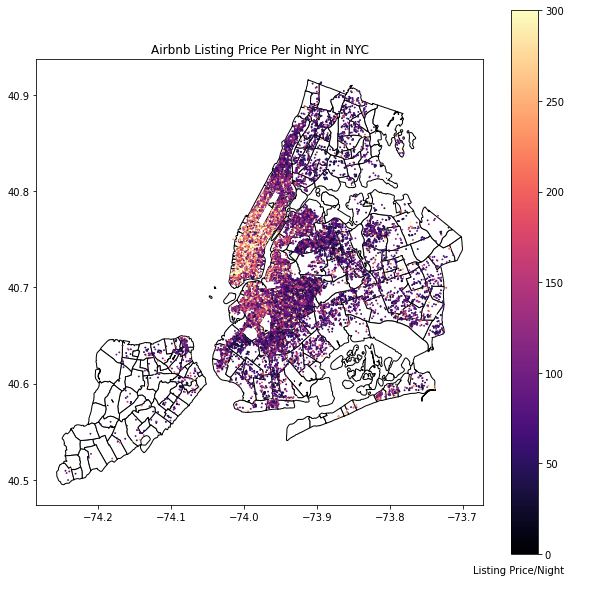

In [ ]:
# Create fig and subaxis
fig, gax = plt.subplots(figsize=(10, 10))

# Plot the countys of NYC
gdf_ny.plot(ax=gax, edgecolor="black", color="white")

# Plot the location of each listing. Create color map for Price
gdf.plot(ax=gax, column = 'price', markersize = .8, vmin=0, vmax=300, legend = True, cmap='magma')

gax.annotate('Listing Price/Night',xy=(0.78, 0.06),  xycoords='figure fraction')

gax.set_title("Airbnb Listing Price Per Night in NYC")